# Air pollution in Delhi, India using Time Series Analysis ARIMA / SARIMA Project

## Libraries and Dataset load

In [1]:
# Import required modules
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
# Explore the data
df = pd.read_csv('india.csv', parse_dates=True, index_col='Date')

In [3]:
df_india_Delhi = df[['PM2.5','PM10','NO2','SO2','O3']]

In [4]:
print(df_india_Delhi.head())

             PM2.5    PM10    NO2   SO2     O3
Date                                          
2015-01-01  313.22  607.98  36.39  9.25  41.68
2015-01-02  186.18  269.55  32.87  6.65  29.97
2015-01-03   87.18  131.90  30.31  2.65  19.71
2015-01-04  151.84  241.84  36.91  4.63  25.36
2015-01-05  146.60  219.13  34.92  3.33  23.20


## Identification

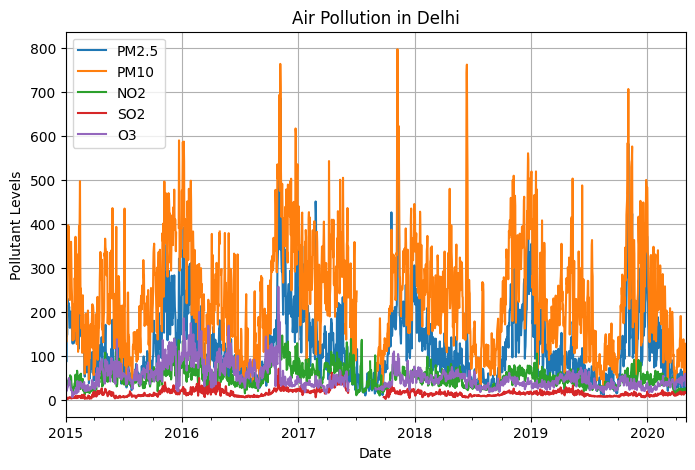

In [6]:
df_india_Delhi.plot(
    figsize=(8,5),
    grid=True,
    title="Air Pollution in Delhi"
)

plt.xlabel("Date")
plt.ylabel("Pollutant Levels")
plt.show()



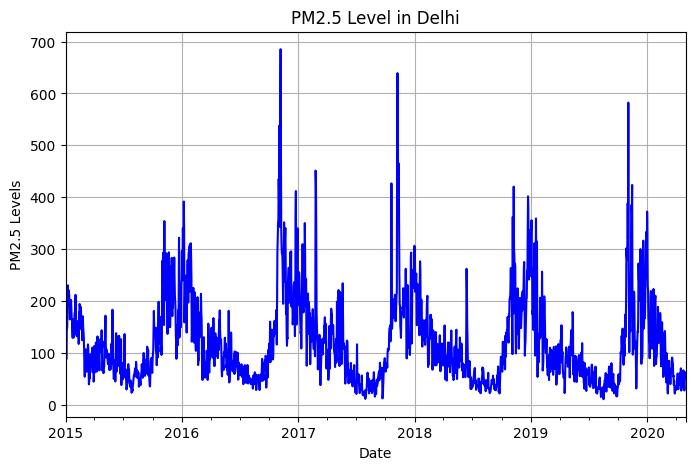

In [7]:
df_PM2_5 = df_india_Delhi['PM2.5']

df_PM2_5.plot(
    figsize=(8,5),
    color='Blue',
    grid=True,
    title="PM2.5 Level in Delhi"
)

plt.xlabel("Date")
plt.ylabel("PM2.5 Levels")
plt.show()

In [8]:
df_PM2_5_withoutna = df_PM2_5.asfreq('ME').ffill()

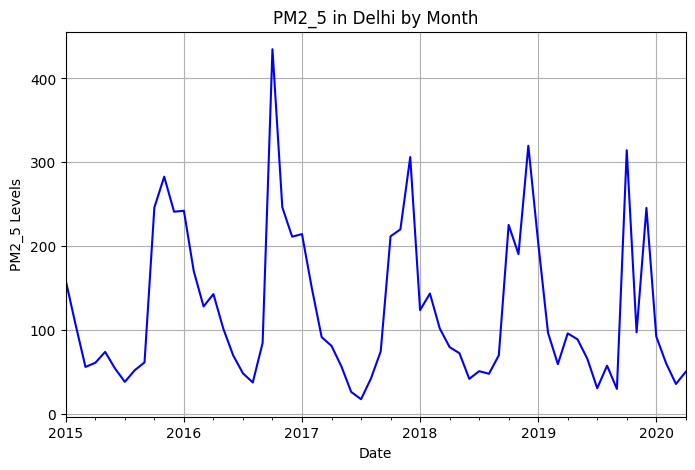

In [18]:
df_PM2_5_withoutna.plot(
    figsize=(8,5),
    color='blue',
    grid=True,
    title="PM2_5 in Delhi by Month"
)

plt.xlabel("Date")
plt.ylabel("PM2_5 Levels")
plt.show()

In [10]:
df_PM2_5_rolling = df_PM2_5.rolling(360).mean()
df_PM2_5_rolling = df_PM2_5_rolling.interpolate()

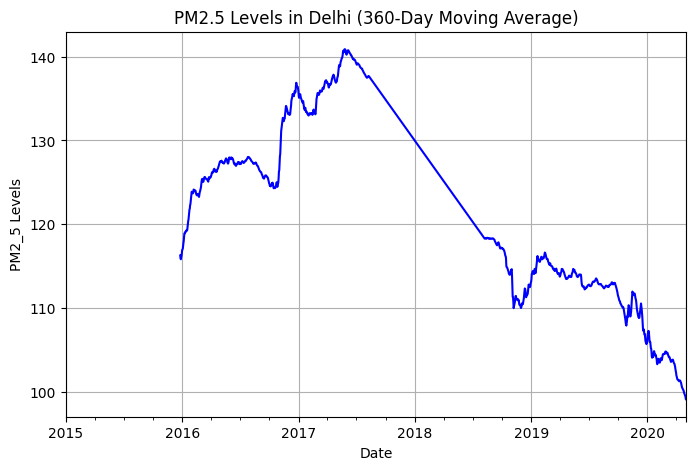

In [19]:
df_PM2_5_rolling.plot(
    figsize=(8,5),
    color='blue',
    grid=True,
    title="PM2.5 Levels in Delhi (360-Day Moving Average)"
)

plt.xlabel("Date")
plt.ylabel("PM2_5 Levels")
plt.show()

In [12]:
df_PM2_5.index = pd.to_datetime(df_PM2_5.index)
df_PM2_5 = df_PM2_5.asfreq('ME').dropna()


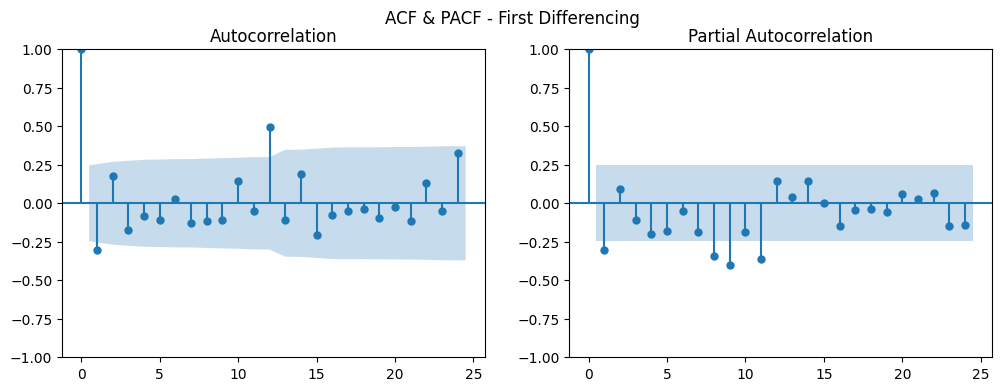

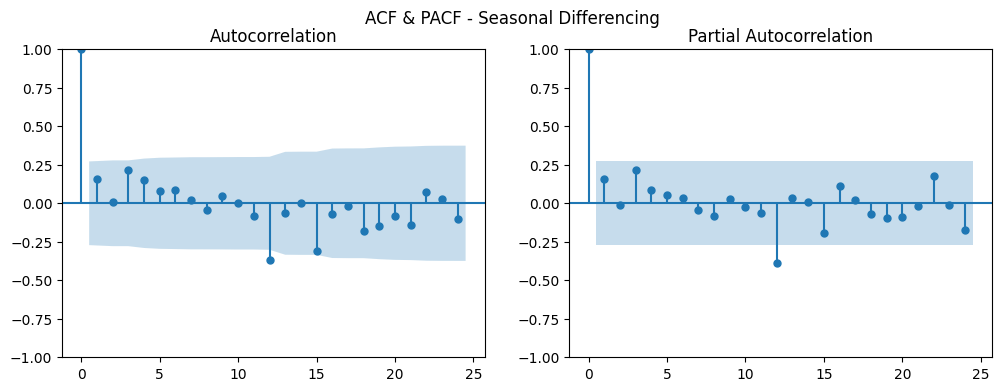

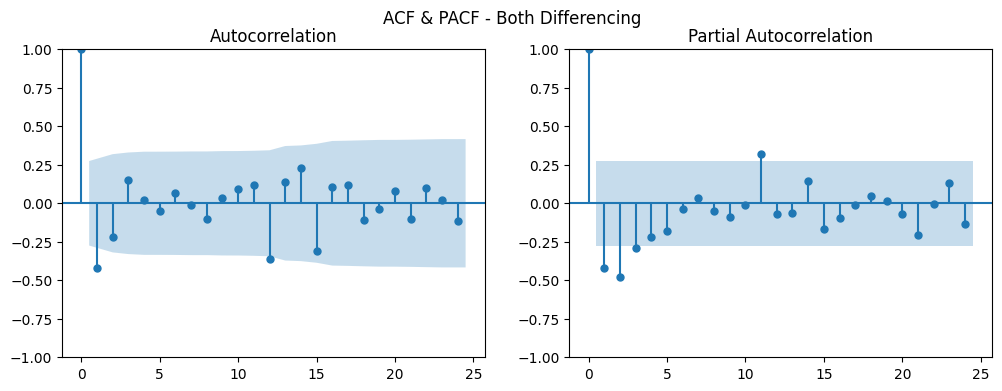

In [21]:
# first diffence
diff1 = df_PM2_5.diff().dropna()
diff2 = diff1.diff().dropna()

# 12 Seasonal difference 
diff_seasonal = df_PM2_5.diff(12).dropna()

# both seasonal and first differnec
diff_both = diff1.diff(12).dropna()

# Detrending using rolling mean (e.g., N=10)
N = 12
df_detrended = df_PM2_5 - df_PM2_5.rolling(window=N).mean()
# Drop NaN values (first N-1 values are NaN due to rolling window)
df_detrended = df_detrended.dropna()

# رسم ACF و PACF للمقارنة
def plot_acf_pacf(ts, title):
    fig, axes = plt.subplots(1,2,figsize=(12,4))
    plot_acf(ts,zero=True, lags=24, ax=axes[0])
    plot_pacf(ts,zero=True, lags=24, ax=axes[1])
    fig.suptitle(title)
    plt.show()
plot_acf_pacf(diff1, "ACF & PACF - First Differencing")
plot_acf_pacf(diff_seasonal, "ACF & PACF - Seasonal Differencing")
plot_acf_pacf(diff_both, "ACF & PACF - Both Differencing")
#plot_acf_pacf(df_detrended, "ACF & PACF - No Sesonal Differencing")

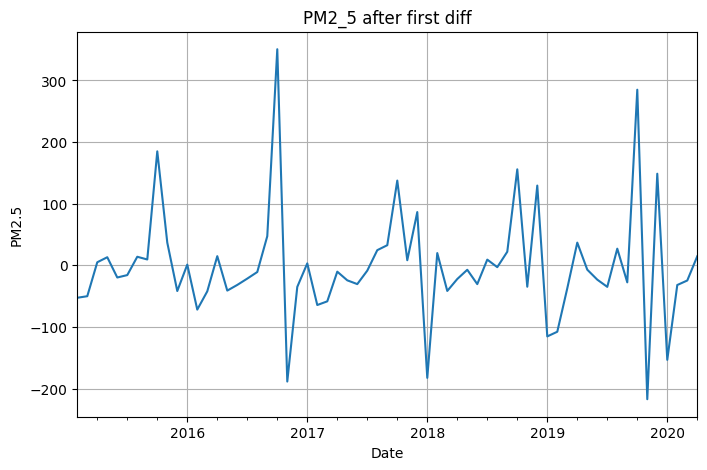

In [22]:
diff1.plot(
    figsize=(8,5),
    grid=True,
    title="PM2_5 after first diff"
)

plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.show()

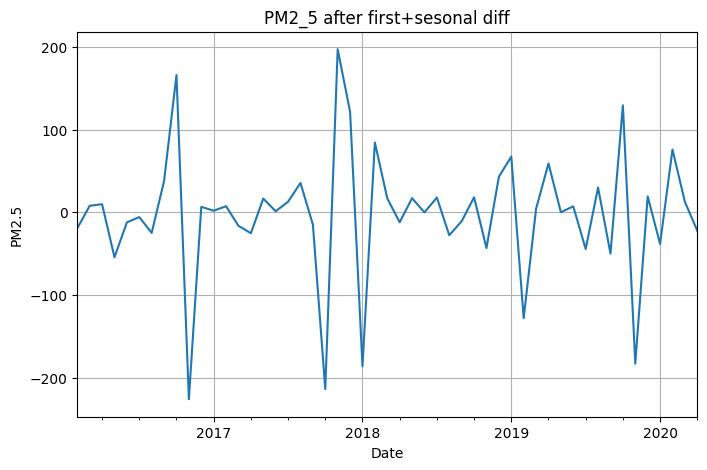

In [24]:
diff_both.plot(
    figsize=(8,5),
    grid=True,
    title="PM2_5 after first+sesonal diff"
)

plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.show()

## Dicky fuller test

In [26]:

def adf_test(series, title="ADF Test"):
    result = adfuller(series.dropna())
    print(title)
    print(f"Result: {result}")
    if result[1] < 0.05:
        print(" Stationary")
    else:
        print("No Stationary")
    print("-"*40)

adf_test(df_PM2_5, "Original Series")
adf_test(diff1, "After First Differencing")
adf_test(diff_seasonal, "After Seasonal Differencing")
adf_test(diff_both, "After Both Differencing")
adf_test(df_detrended, "After Non-seasonal differencing Differencing")

Original Series
Result: (-0.3900829213624242, 0.9117414531540184, 11, 52, {'1%': -3.562878534649522, '5%': -2.918973284023669, '10%': -2.597393446745562}, 590.7464791622938)
No Stationary
----------------------------------------
After First Differencing
Result: (-8.30710421070434, 3.877076652417254e-13, 10, 52, {'1%': -3.562878534649522, '5%': -2.918973284023669, '10%': -2.597393446745562}, 576.542858556311)
 Stationary
----------------------------------------
After Seasonal Differencing
Result: (-6.064184896683302, 1.19267957294279e-07, 0, 51, {'1%': -3.5656240522121956, '5%': -2.920142229157715, '10%': -2.598014675124952}, 437.98374959588403)
 Stationary
----------------------------------------
After Both Differencing
Result: (-7.272365742388234, 1.5762296347150443e-10, 2, 48, {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}, 435.0999904759374)
 Stationary
----------------------------------------
After Non-seasonal differencing Differencing
Result: (

## Estimation

In [29]:
# Define ranges for non-seasonal and seasonal parameters
p_values = range(3)   # AR order
d_values = [1]        # differencing
q_values = range(3)   # MA order

P_values = range(3)   # seasonal AR
D_values = [1]        # seasonal differencing
Q_values = range(3)   # seasonal MA
s = 12                # seasonal period

# Store results
results_list = []

# Full grid search
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        try:
                            model = SARIMAX(
                                diff1,
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, s),
                                enforce_stationarity=False,
                                enforce_invertibility=False
                            )
                            results = model.fit(disp=False)
                            results_list.append({
                                'p': p, 'd': d, 'q': q,
                                'P': P, 'D': D, 'Q': Q,
                                'AIC': results.aic,
                                'BIC': results.bic
                            })
                        except:
                            continue

# Convert to DataFrame and sort by AIC
results_df = pd.DataFrame(results_list)
results_df_sorted = results_df.sort_values('AIC').reset_index(drop=True)

print("Top models by AIC:")
print(results_df_sorted.head(10))  # Show top 10


C:\Users\HP B.DESKTOP-20RBB06\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\HP B.DESKTOP-20RBB06\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\HP B.DESKTOP-20RBB06\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\HP B.DESKTOP-20RBB06\anaconda3\Lib\site-packages\statsmodels\tsa

Top models by AIC:
   p  d  q  P  D  Q         AIC         BIC
0  0  1  2  2  1  2  247.862772  255.811231
1  0  1  2  0  1  2  249.173680  254.851151
2  1  1  2  2  1  2  249.630616  258.714570
3  1  1  2  0  1  2  251.063356  257.876321
4  0  1  2  1  1  2  251.200222  258.013187
5  2  1  2  0  1  2  252.352012  260.300471
6  1  1  2  1  1  2  253.107828  261.056288
7  2  1  2  1  1  2  254.351967  263.435920
8  2  1  2  2  1  2  255.635761  265.855209
9  1  1  1  0  1  2  260.354782  266.245052


C:\Users\HP B.DESKTOP-20RBB06\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
# Fit SARIMA
model = SARIMAX(
    diff1,
    order=(0, 1, 2),           # non-seasonal (p,d,q)
    seasonal_order=(0, 1, 2, 12)  # seasonal (P,D,Q,s)
)

results = model.fit()
results.summary()

C:\Users\HP B.DESKTOP-20RBB06\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\HP B.DESKTOP-20RBB06\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              PM2.5   No. Observations:                   63
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -272.332
Date:                            Wed, 17 Sep 2025   AIC                            554.663
Time:                                    21:19:38   BIC                            564.224
Sample:                                02-28-2015   HQIC                           558.304
                                     - 04-30-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.8076      0.090    -20.071      0.000      -1.984      -1.631
ma.L2          0.8707      0.085     10.292      0.000       0.705       1.037
ma.S.L12      -0.8597      1.011     -0.851      0.395      -2.840       1.121
ma.S.L24       0.0022      0.260      0.008      0.993      -0.507       0.511
sigma2      2221.9052   2133.048      1.042      0.298   -1958.793    6402.603
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 9.38
Prob(Q):                              0.68   Prob(JB):                         0.01
Heteroskedasticity (H):               1.26   Skew:                             0.51
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

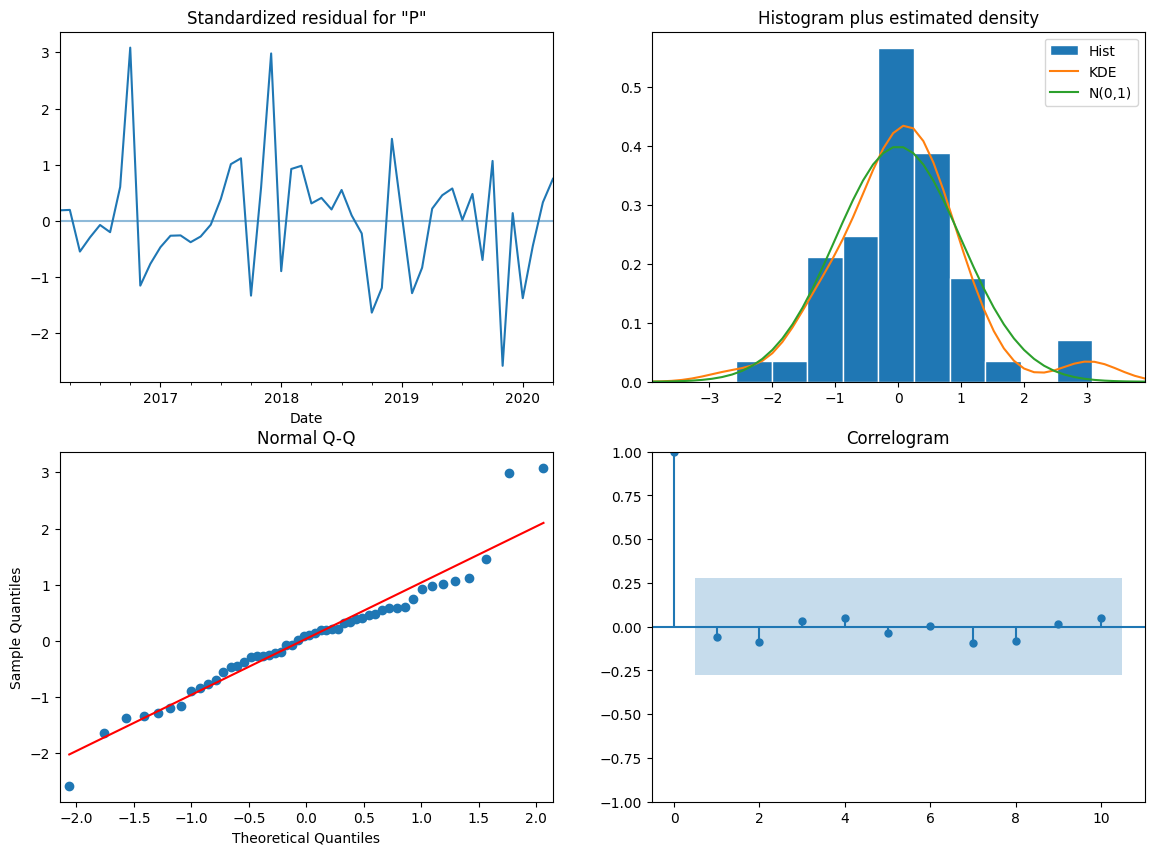

In [38]:
# Create the 4 diagnostics plots
results.plot_diagnostics(figsize=(14, 10))
plt.show()

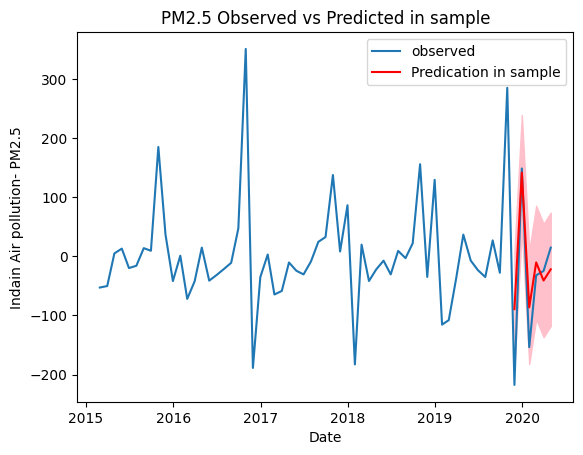

In [39]:
one_step_forecast = results.get_prediction(start=-6,Dynamic=True)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()
# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower PM2.5']
upper_limits = confidence_intervals.loc[:,'upper PM2.5']
# plot the amazon data
plt.plot( diff1.index,  diff1, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='Predication in sample')
# shade the area between your confidence limits
plt.fill_between(mean_forecast.index, lower_limits, 
                 upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Indain Air pollution- PM2.5')
plt.title('PM2.5 Observed vs Predicted in sample')
plt.legend()
plt.show()


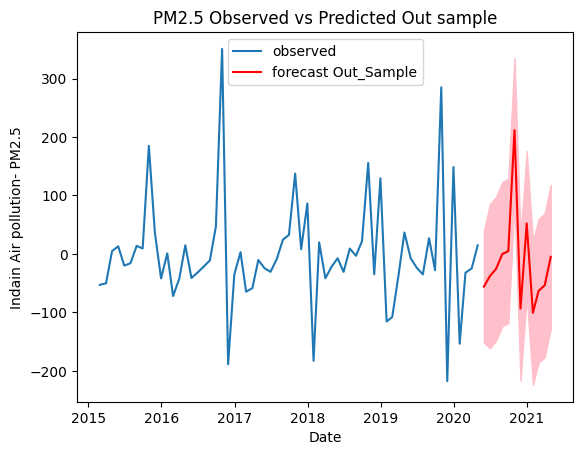

In [40]:
# Forecast out-of-sample for the next 12 steps
forecast = results.get_forecast(steps=12,dynamic=True)

# Extract forecasted mean values
mean_forecastf = forecast.predicted_mean

# Get confidence intervals (95% by default)
confidence_intervalsf = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervalsf.loc[:,'lower PM2.5']
upper_limits = confidence_intervalsf.loc[:,'upper PM2.5']

# plot the amazon data
plt.plot(diff1.index, diff1, label='observed')

# plot your mean predictions
plt.plot(mean_forecastf.index, mean_forecastf, color='r', label='forecast Out_Sample')
# shade the area between your confidence limits
plt.fill_between(mean_forecastf.index, lower_limits, 
                 upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Indain Air pollution- PM2.5')
plt.title('PM2.5 Observed vs Predicted Out sample')
plt.legend()
plt.show()